# Studying Forest Fires using Automatons

Coarse grained, simplified descriptions of complex systems is useful when the underlying systems have a lot of parameters and complicated microscopic behaviour. Finite computational resources and time can be spent on studying the features that are retained in the coarse grained description instead of worrying about fine-grained behaviour in microscopic detail. In these notes, we use this approach to study forest fires on lattices. Using stochastic rules for the evolution of the lattice, several important features are found including critical behaviour in the forest fire model. We demonstrate this in python, along with an optimised firefighting strategy to limit the damage due to fires.

The general approach here uses cellular automatons : lattice sites that take a finite number of values (called states) with some probabilistic rules for evolution for every time step. Given some geographical data, one can coarse grain small regions in it to assign one of the possible values to the corresponding automaton, and the parameters at that site. Then with evolution rules that capture the richness of forest fire dynamics, we can simulate and study various aspects of forest fires.

Here we consider sites that can be in __3 possible states__ :
1. __'t'__ : corresponding to a tree at the site (forested on average).
2. __'e'__ : corresponding to an empty site (a site that is not vegetated and does not burn).
3. __'b'__ : corresponding to a burning tree (region that is on fire at a given time).

Let us start with a model with __three parameters__ defined on every site :
1.  __Growth probability__ : $p$, or Tree growth time : $p^{-1}$. This represents the state transition from the state 'e' $\rightarrow$ 't'.

2. __Fire initiation probability__ : $f$, or Time after which a fire is likely to start due to lightning strikes (or a variety of other factors) $f^{-1}$.

3. __Immunity__ $g$ to model the fire spread dynamics. Given a neighbor on fire, a site catches fire with probability $1-g$. The parameters $f$ and $g$ are responsible for the transition 't' $\rightarrow$ 'b'.

4. Each site is updated once in a time step and every state 'b' changes to 'e', that is a site burns through in one time step.

One can imagine many more parameters and states to model forest behaviour under the influence of fires, but this scenario is minimal with only one parameter for tree growth, fire initiation and fire spread. Instead of starting with geographical data, we start with random lattices representing some specific forest configurations. After learning how to model the dynamics of this model on a random lattice, it is not hard to generalise this approach by coarse graining geographical data to get the initial lattice, historical data to get parameters which can even be localised for more detail and then applying the model. In general, the larger the lattice, the finer features it captures.

## Square Lattices

We first generate a random square lattice of length 1024. The green sites represent forested regions. There are no fires initially.

In [1]:
# Importing packages.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
import random
from scipy.optimize import curve_fit

In [2]:
def initialize_forest(p_tree, length):
    '''
    Generates a random lattice with trees and empty sites. An initialising probability controls the density.
    :param p_tree: Probability of a tree at a point.
    :param length: size of the lattice is square of the length for square lattice.
    :return: lattice
    '''
    forest = np.random.choice(['e', 't'], p = [1-p_tree, p_tree], size=(length, length))
    return forest

Text(0.5, 1.0, 'Random forest')

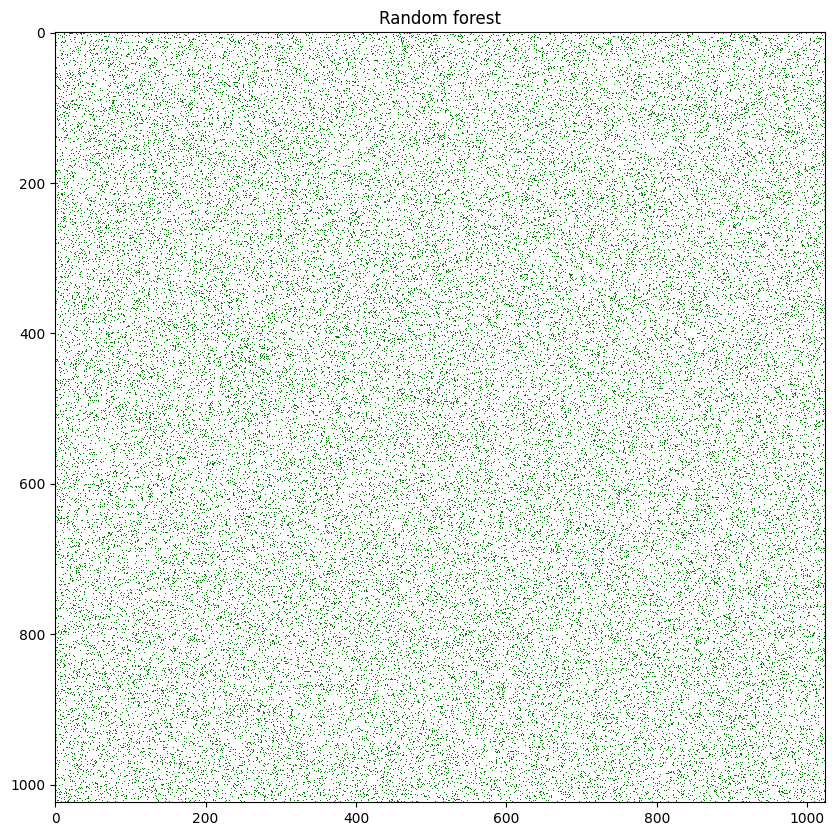

In [9]:
forest = initialize_forest(p_tree = 0.10, length = 1024) # A random forest
char_to_int = {'e': 0, 't': 1, 'b': 2}  # Character grid for vectorizing the forest
burncolors = ListedColormap(['white', 'green', 'red'])   # Custom colormap
plt.figure(figsize=(10,10))   # Plot for displaying the forest configuration
vec_forest = np.vectorize(char_to_int.get)(forest)
plt.imshow(vec_forest, cmap=burncolors, interpolation = 'none', vmin = 0, vmax = 2)
plt.title('Random forest')

In [10]:
# Initialising a lattice using a Probability Matrix - local probability values on the lattice.
def p_init_matrix(length):
    probmat = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            probmat[i][j] = i*j/length/length

    return probmat

def initialize_forest_custom(prob_mat, length):
    init_forest = np.full((length, length), 'e')
    for i in range(length):
        for j in range(length):
            init_forest[i][j] = np.random.choice(['e', 't'], p = [1-prob_mat[i][j], prob_mat[i][j]])

    return init_forest



For scenarios where the initial configuration is not completely random (for ex, geospatial data), we can use some probability matrix to generate the initial forest. Here, we see a forest with trees concentrated towards the bottom right.

Text(0.5, 1.0, 'Random forest with local site control')

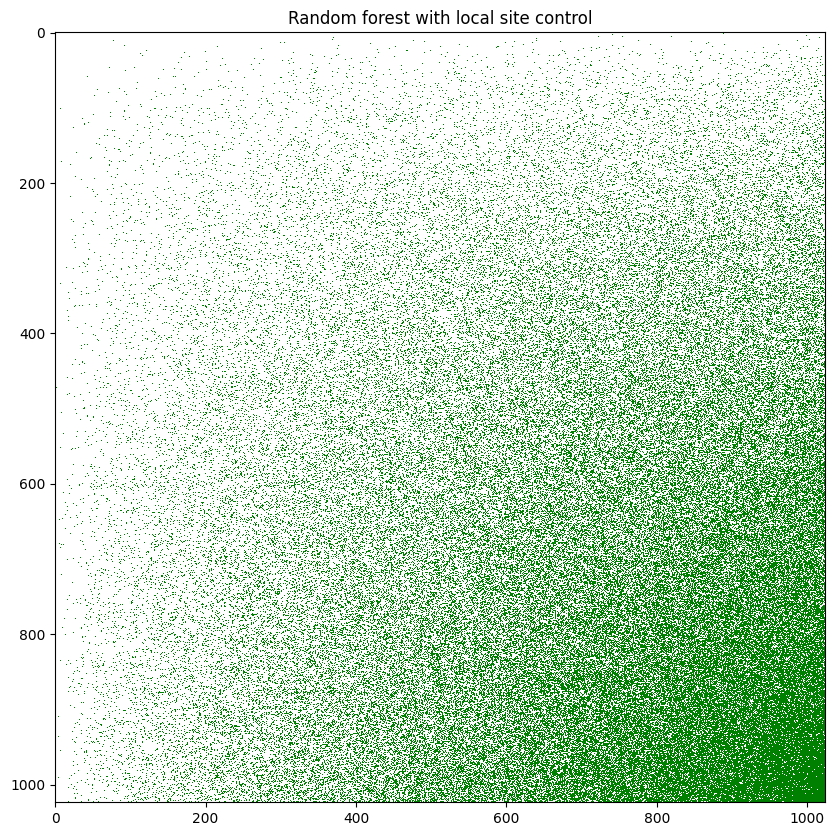

In [31]:
custom_forest = initialize_forest_custom(p_init_matrix(1024), 1024)
plt.figure(figsize=(10,10))   # Plot for displaying the forest configuration
vec_custom_forest = np.vectorize(char_to_int.get)(custom_forest)
plt.imshow(vec_custom_forest, cmap=burncolors, interpolation = 'none', vmin = 0, vmax = 2)
plt.title('Random forest with local site control')

The rules for time evolution were mentioned above. For a given timestep, they can be expressed in python as follows:

In [14]:
def update_forest(forest, gmat, p, f):
    '''
    A function to update the forest.
    :param forest: Initial forest state as an array.
    :param gmat: A matrix of immunity values defined on the lattice for every site.
    :param p: Growth Probability for each site. Is more generally also a matrix but we assume constant growth rate here.
    :param f: Fire initiation probability. Also assumed to constant over the lattice. In general, certain regions would be more suceptible to fire initiation.
    :return: Updated forest state as an array.
    '''
    new_forest = forest.copy()
    size = forest.shape[0]

    for i in range(size):
        for j in range(size):
            if forest[i,j]=='b':
                new_forest[i,j] = 'e'
            if forest[i,j] == 'e':
                 if np.random.binomial(1,p)==1:
                     new_forest[i,j]='t'
            if forest[i,j]=='t':
                if np.random.binomial(1, f) == 1:
                    new_forest[i, j] = 'b'
                if forest[max(i-1,0),j]=='b' or forest[min(i+1,size-1),j]=='b' or forest[i,max(j-1,0)]=='b' or forest[i,min(j+1,size-1)]=='b':
                    if np.random.binomial(1, 1-gmat[i,j])==1:
                        new_forest[i,j]='b'


    return new_forest

On a simple 100 $\times$ 100 lattice, the update rule evolves the lattice like this.

Text(0.5, 1.0, 'Forest Update Rules (t=0)')

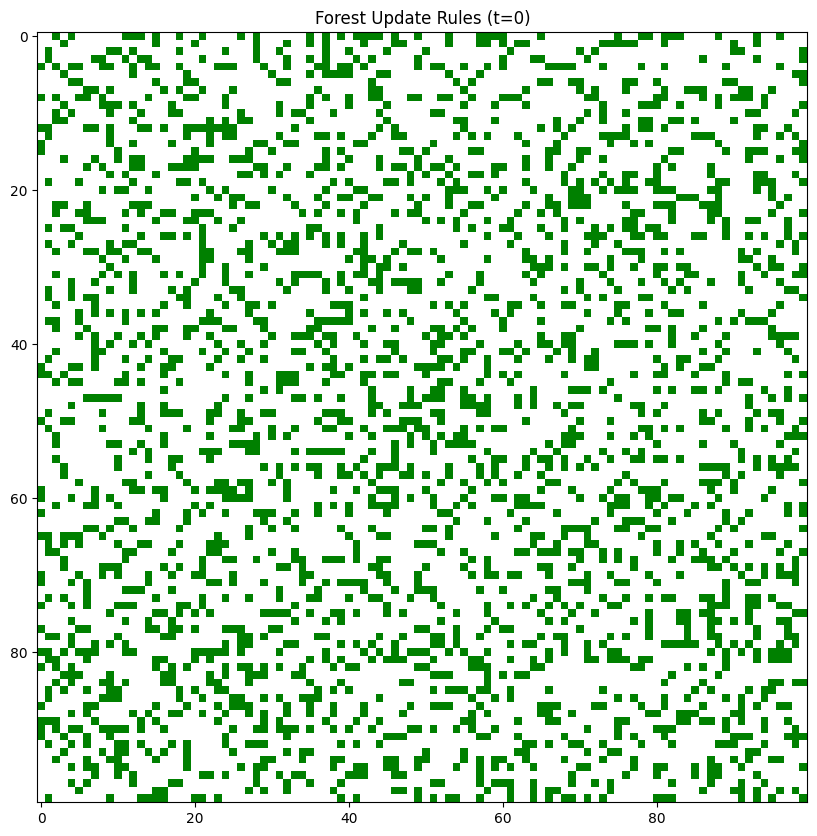

In [17]:
forest_ten_i = initialize_forest(0.25, 100)
plt.figure(figsize=(10,10))   # Plot for displaying the forest configuration
vec_forest_ten_i = np.vectorize(char_to_int.get)(forest_ten_i)
plt.imshow(vec_forest_ten_i, cmap=burncolors, interpolation = 'none', vmin = 0, vmax = 2)
plt.title('Forest Update Rules (t=0)')

We can observe fires starting in the $t=1$ frame if the fire initiation probability $f$ is high enough.

Text(0.5, 1.0, 'Forest Update Rules (t = 1)')

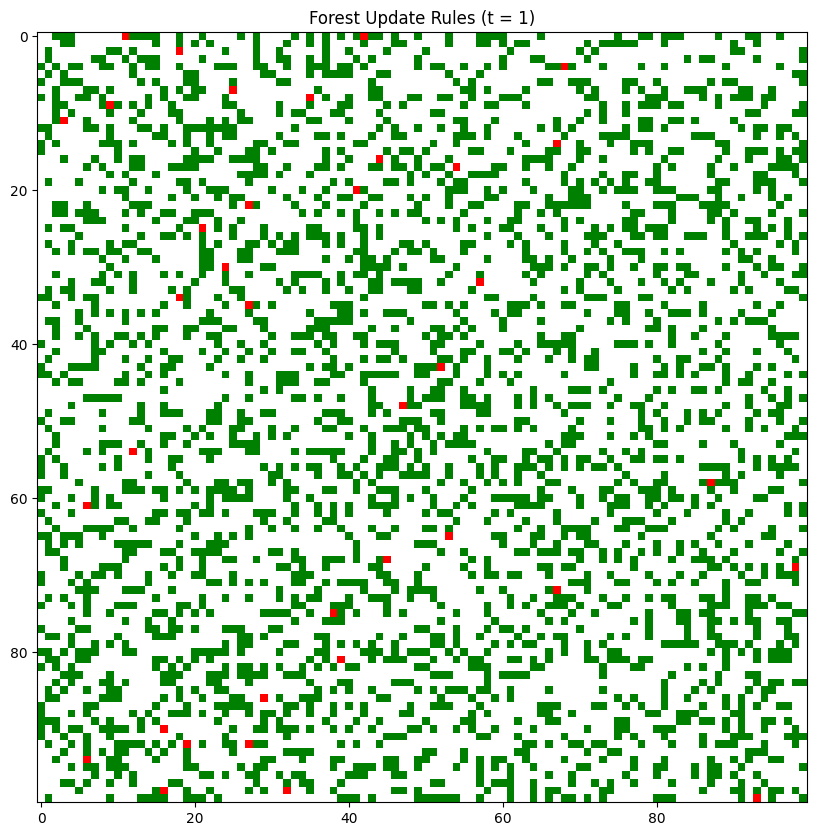

In [18]:
immunity_mat = np.zeros((100,100))
plt.figure(figsize=(10,10))   # Plot for displaying the forest configuration
forest_ten_f = update_forest(forest_ten_i, immunity_mat, 0.05, 0.02)
vec_forest_ten_f = np.vectorize(char_to_int.get)(forest_ten_f)
plt.imshow(vec_forest_ten_f, cmap=burncolors, interpolation = 'none', vmin = 0, vmax = 2)
plt.title('Forest Update Rules (t = 1)')

And fire spreading in the $t=2$ frame for $g < 1$, along with tree growth

Text(0.5, 1.0, 'Forest Update Rules (t = 2)')

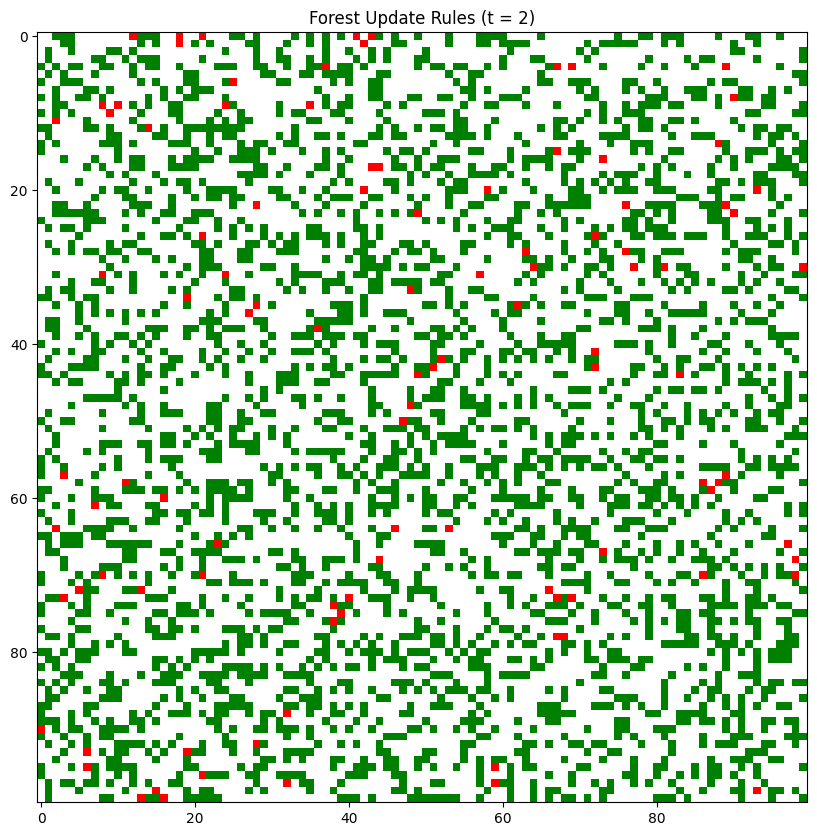

In [19]:
plt.figure(figsize=(10,10))   # Plot for displaying the forest configuration
forest_ten_ff = update_forest(forest_ten_f, immunity_mat, 0.05, 0.02)
vec_forest_ten_ff = np.vectorize(char_to_int.get)(forest_ten_ff)
plt.imshow(vec_forest_ten_ff, cmap=burncolors, interpolation = 'none', vmin = 0, vmax = 2)
plt.title('Forest Update Rules (t = 2)')

Every lattice configuration tree clusters. Any tree with a nearest neighbor tree is part of the same cluster. For example, the above configurations of trees have cluster sizes that evolves in time as well.


In [28]:
# The cluster sizes can be found using a recursive function.
def find_cluster_sizes(lattice):
    '''
    :param lattice: Forest configuration in two dimensions. A simple analog can be written for single dimensional lattices too.
    :return: cluster sizes with size bigger than 1
    '''
    cluster_sizes = []
    rows, cols = lattice.shape
    visit_condition = np.zeros_like(lattice, dtype=bool)

    def cluster_size(i, j, cs):
        if i<0 or i>=rows or j<0 or j>=cols or visit_condition[i,j] or lattice[i,j]!='t':
            return cs
        cs+=1
        visit_condition[i,j] = True
        cs = cluster_size(i+1, j, cs)
        cs = cluster_size(i-1, j, cs)
        cs = cluster_size(i, j+1, cs)
        cs = cluster_size(i, j-1, cs)

        return cs

    for i in range(rows):
        for j in range(cols):
            if lattice[i,j] == 't' and not visit_condition[i,j]:
                csize = cluster_size(i,j,0)
                if csize>1:
                    cluster_sizes.append(csize)

    return cluster_sizes


The cluster distributions evolve as follows:


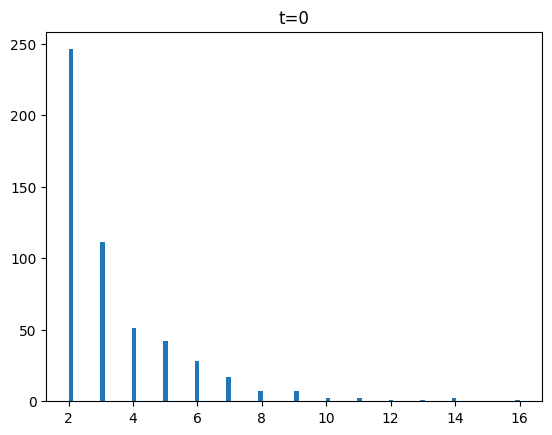

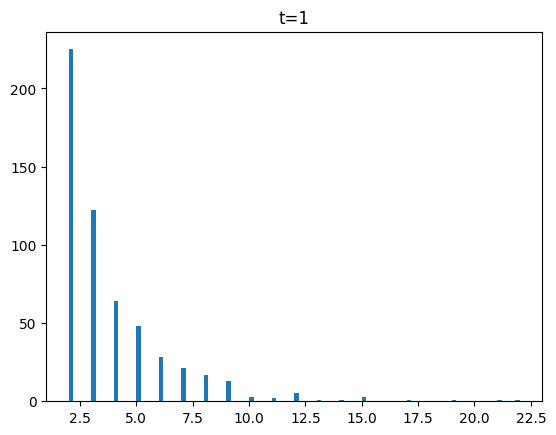

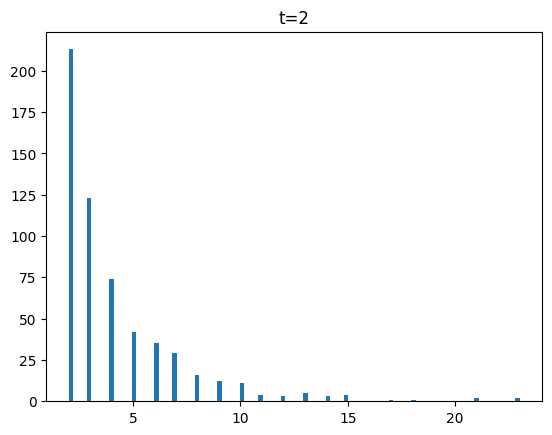

In [22]:
plt.hist(find_cluster_sizes(forest_ten_i), bins = 100)
plt.title('t=0')
plt.show()
plt.hist(find_cluster_sizes(forest_ten_f), bins = 100)
plt.title('t=1')
plt.show()
plt.hist(find_cluster_sizes(forest_ten_ff), bins = 100)
plt.title('t=2')
plt.show()


and the 1024 $\times$ 1024 forest has cluster sizes that look like the following on a histogram :

Text(0.5, 1.0, 'Clusters for a random forest')

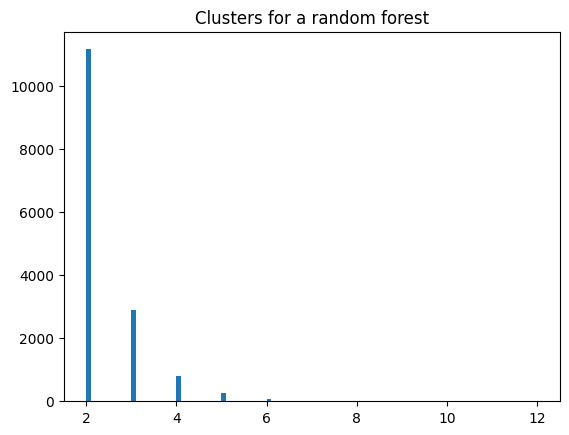

In [32]:
clusters_1024 = find_cluster_sizes(forest)
plt.hist(clusters_1024, bins = 100)
plt.title('Clusters for a random forest')

Using the forest update rules, we can evolve a randomly generated initial forest state. We do this for a $1024 \times 1024$ size lattice by evolving it over 15000 steps with the following parameter values:

$p = 0.001$

$f = 0.001/500$

$g = 0.1$

We plot the fraction of sites with trees, that are empty and are burning over the evolution of the system.

![Fractions as functions of time](number_timesteps.png)

When the forest fractions are fluctuating wildly - there are burn and growth phases and the time evolution is captured by the animation :

In [35]:
from IPython.display import HTML

# Path to your .mp4 video file
video_path = "10k_video_sim.mp4"  # Replace with your file path

# Generate HTML to embed the video
video_html = f"""
<video width="640" height="480" controls>
    <source src="{video_path}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

# Display the video inline
HTML(video_html)


Later, as the systems moves towards equilibrium and the fluctuations are smaller, we record the simulation by restarting the forest update at t = 10000 time steps :

In [200]:
# Path to your .mp4 video file
video_path = "2k_video_sim.mp4"  # Replace with your file path

# Generate HTML to embed the video
video_html = f"""
<video width="640" height="480" controls>
    <source src="{video_path}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

# Display the video inline
HTML(video_html)


Near equilibrium, the cluster sizes follow the distribution pattern:

(array([203.,  36.,  27.,  17.,  10.,   8.,   5.,   4.,   2.,   2.,   5.,
          3.,   0.,   1.,   1.,   4.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  101.  ,   281.05,   461.1 ,   641.15,   821.2 ,  1001.25,
         1181.3 ,  1361.35,  1541.4 ,  1721.45,  1901.5 ,  2081.55,
         2261.6 ,  2441.65,  2621.7 ,  2801.75,  2981.8 ,  3161.85,
         3341.9 ,  3521.95,  3702.  ,  3882.05,  4062.1 ,  4242.15,
         4422.2 ,  4602.25,  4782.3 ,  4962.35

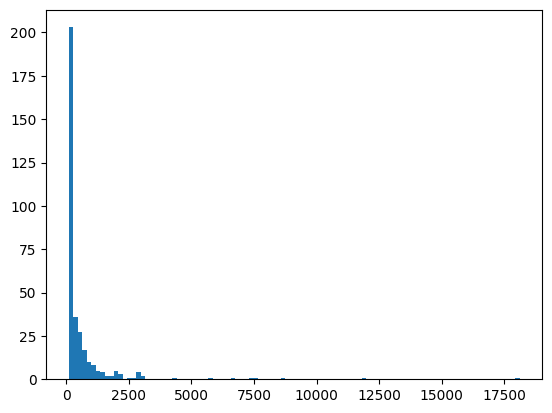

In [38]:
forest3kdf = pd.read_csv('forest3k.csv')
forest_lattice_df = forest3kdf[forest3kdf.columns[1:]]
clusters = find_cluster_sizes(forest_lattice_df.to_numpy())
clusters = np.array(clusters)
clusters = clusters[clusters>100]
plt.hist(clusters, bins = 100)
# plt.ylim(0, 1000)  # Set y-axis limits from 0 to 50


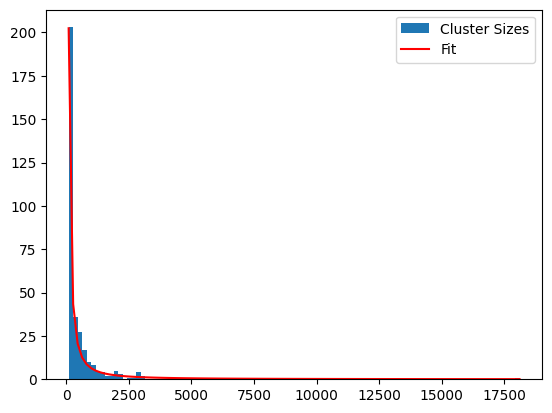

In [39]:
hist_twod, bins_twod = np.histogram(clusters, bins=100)


def power_law(x, a, b):
    return a * x ** (-b)


# Fit the curve
params, _ = curve_fit(power_law, bins_twod[:-1], hist_twod)
# Plot the histogram and the fitted curve
plt.hist(clusters, bins=100, label='Cluster Sizes')
plt.plot(bins_twod, power_law(bins_twod, *params), 'r-', label='Fit')
plt.legend()
plt.show()


In [40]:
print(params)

[2.11837614e+05 1.50660215e+00]


We find that the power law fit does not do so well for the two dimensional configuration. Later we will see that for the one dimensional forest evolution under certain assumptions at equilibrium, we would be able to find a very good fit using a power law function demonstrating that we were able to find critical behaviour in this fire model for one dimension. Such a power law signifies a __catastrophe__ as very large fires are possible due to the slowness of the power law decay compared with exponential decay in the occurrence of large clusters.

### Including Firefighters in the model dynamics

Next, we study a modification of forest fire evolution when there are firefighters in action to suppress the fires. We model firefighter action as follows :

Local action of a firefighter at a site effectively increases the immunity at a site. Since firefighting is always a finite resource, it is setup to act in a way that minimises a quantity that we call fire damage. First we define __Fire Damage__. To do so, we start with a matrix of damage values defined on the lattice sites of the forest. At each forest site, we assign a damage value which increases the total damage by that value when the state at that cell is that of a burning tree.

A simple firefighting model involves a certain number of firefighters $F_n$, each of which act on a certain site and maximise the immunity at that site $g = 1$ so that the fire does not spread to that site. So, if there are enough firefighters to engulf a lightning strike that starts a fire, they can effectively cutoff the fire spread from that strike.

In [41]:
# A possible definition for the Damage Matrix
def damage_mat(length):
    '''
    A function for defining how the damage matrix is calculated.
    :param length: size of the forest lattice, equivalently also of the damage matrix.
    :return: the damage matrix with damage values.
    '''
    damage_mat = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            damage_mat[i,j] = (i+j)/length
    return damage_mat


We assume a damage matrix of the form :

$D(x,y) = (x+y)/2$

Next, we construct a function that finds all the nearest neighbors of a given list of indices. We randomly sample a large number of times through neighbors of burning trees to assign firefighters at some set of neighbors, then we do a trial evolution and calculate the total damage at the new time step with firefighters active. If we do this a large number of times, we are able to find optimal or close to optimal assignment of firefighters for fighting the fires to keep the damage low.

In [43]:
def find_neighbors(arr, row_indices, col_indices):
    """
    Finds the indices of neighboring elements in a 2D array.

    Args:
        arr: The 2D NumPy array.
        row_indices: A 1D array of row indices.
        col_indices: A 1D array of column indices.

    Returns:
        A tuple of two 1D arrays: neighbor_row_indices and neighbor_col_indices.
    """
    rows, cols = arr.shape
    neighbor_row_indices = []
    neighbor_col_indices = []

    for i, j in zip(row_indices, col_indices):
        for x in [-1, 0, 1]:
            for y in [-1, 0, 1]:
                if abs(x) + abs(y) != 0 and 0 <= i + x < rows and 0 <= j + y < cols : #exclude self
                  neighbor_row_indices.append(i+x)
                  neighbor_col_indices.append(j+y)

    return neighbor_row_indices, neighbor_col_indices



The firefighting function is run with forest plots for a few steps to show how firefighting affects the forest evolution. The blue dots are the firefighters, $F_n = L/2$.

In [44]:
def discrete_run_simulation(length, g_0, ff_value, p, f, steps):
    '''
    A function for updating the forest according to new immunity values updated at every step by optimised firefighter action that minimises the total damage.
    :param length: A forest is initialised with this length randomly with tree probability 0.5.
    :param g_0: Baseline Immunity without firefighter action at each site.
    :param ff_value: Whether firefighters are activated (value = 1) or not (value = 0).
    :param p: growth probability.
    :param f: lightning strike probability.
    :param steps: the number of time steps for the simulation.
    :return: Burn trees, trees, empty sites and damage as a function of time and the final forest state so that simulations can be continued.
    '''
    forest = initialize_forest(0.5, length)
    plt.figure(figsize=(10,10))
    trial_dam_num = 0
    counts_b = np.zeros(steps)
    counts_t = np.zeros(steps)
    counts_e = np.zeros(steps)
    damage = np.zeros(steps)
    dmat = damage_mat(length)

    for step in range(steps):
        if ff_value == 1:
          gmat = np.full((length, length), g_0)    # Immunity Matrix with all values set to g_0
          vec_forest = np.vectorize(char_to_int.get)(forest)

          plt.imshow(vec_forest, cmap=burncolors, interpolation = 'none', vmin = 0, vmax = 2)
          plt.title(f"Step {step}")
          plt.pause(0.5)

          indices = np.where(forest == 'b')  # locations where the forest has burning trees.
          neighbor_rows, neighbor_cols = find_neighbors(forest, indices[0], indices[1]) # find all neighbors of burning trees.
          # Combine row and column indices into a list of (row, col) tuples
          neighbors = list(zip(neighbor_rows, neighbor_cols))

          # Randomly select L neighbors (or fewer if there are not enough). We assume there are L/2 firefighters.
          num_neighbors_to_select = min(int(length/2), len(neighbors))
          dam_num = 10**12
          min_selected_neighbors = []
          # check L neighbor combinations randomly.
          for i in range(length):
            optimisation_gmat = gmat.copy()
             # No of samplings needs to be considered carefully. For now, we use L.
            selected_neighbors = random.sample(neighbors, num_neighbors_to_select)
            for row, col in selected_neighbors:
              optimisation_gmat[row, col] = 1
            optimisation_forest = update_forest(forest, optimisation_gmat, p, f)
            trial_dam_num = np.sum(dmat[optimisation_forest=='b'])
            if trial_dam_num < dam_num:
              min_selected_neighbors = selected_neighbors
              dam_num = trial_dam_num

          # Create a copy of vec_forest to modify for plotting
          vec_forest_plot = vec_forest.copy()

          # Highlight selected neighbors in blue in the plot
          for row, col in min_selected_neighbors:
              vec_forest_plot[row, col] = 3 # Assign a new value for blue color


          #Extend the colormap to include blue
          newcolors = np.vstack((burncolors(np.linspace(0, 1, 3)), np.array([0, 0, 1, 1]))) #Add blue
          newcmp = ListedColormap(newcolors)

          plt.imshow(vec_forest_plot, cmap=newcmp, interpolation = 'none', vmin = 0, vmax = 3) # use the extended colormap

          plt.pause(0.5)
        # Update forest according to the minimal damage choice.
          for row, col in min_selected_neighbors:
              gmat[row, col] = 1
          forest = update_forest(forest, gmat, p, f )
          damage[step] = np.sum(dmat[forest=='b'])
          counts_b[step] = np.count_nonzero(forest == 'b')
          counts_t[step] = np.count_nonzero(forest == 't')
          counts_e[step] = np.count_nonzero(forest == 'e')
        else:
          vec_forest = np.vectorize(char_to_int.get)(forest)
          plt.imshow(vec_forest, cmap=burncolors, interpolation = 'none', vmin = 0, vmax = 2)
          plt.title(f"Step {step}")
          plt.pause(0.5)
          gmat = np.full((length, length), g_0)
          forest = update_forest(forest, gmat, p, f)
          damage[step] = np.sum(dmat[forest=='b'])
          counts_b[step] = np.count_nonzero(forest == 'b')
          counts_t[step] = np.count_nonzero(forest == 't')
          counts_e[step] = np.count_nonzero(forest == 'e')


    return counts_b, counts_t, counts_e, damage, forest




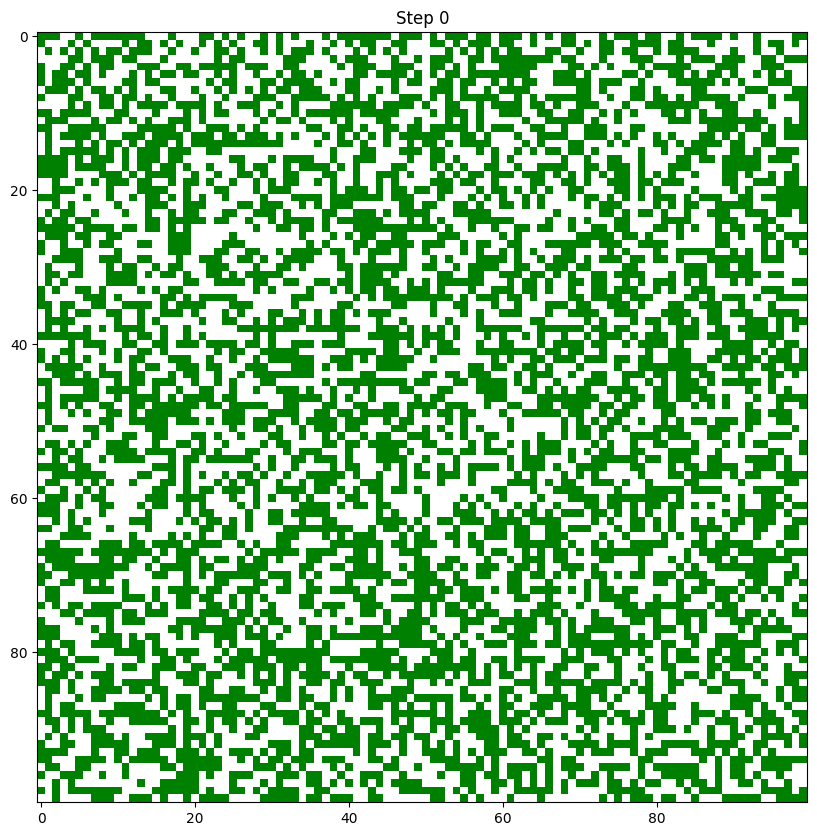

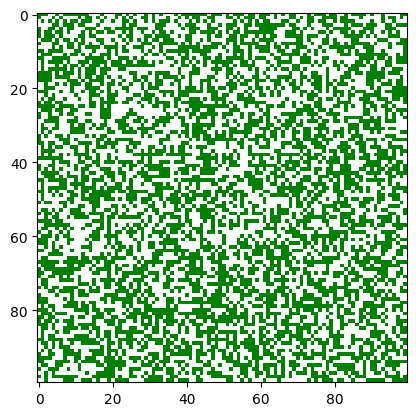

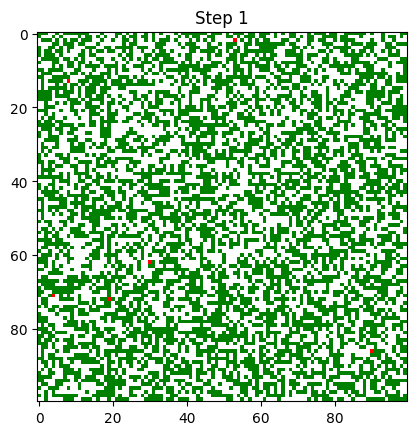

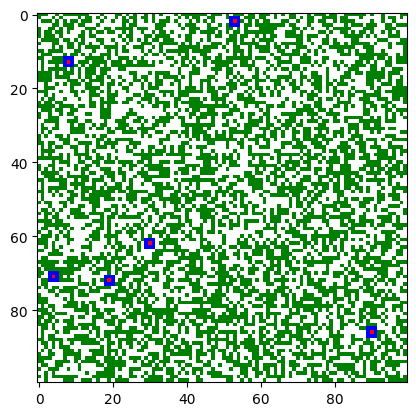

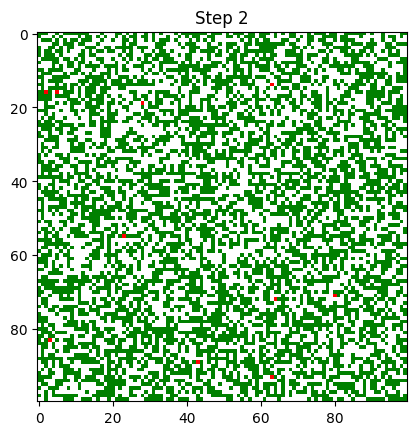

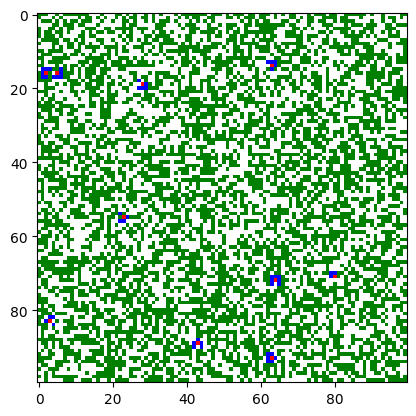

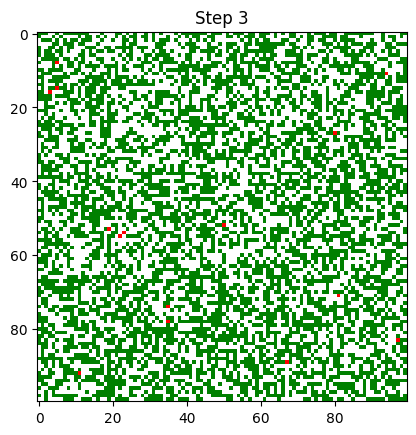

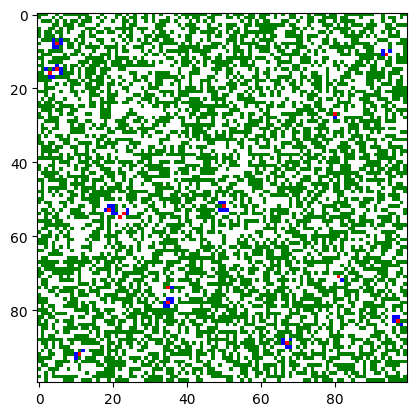

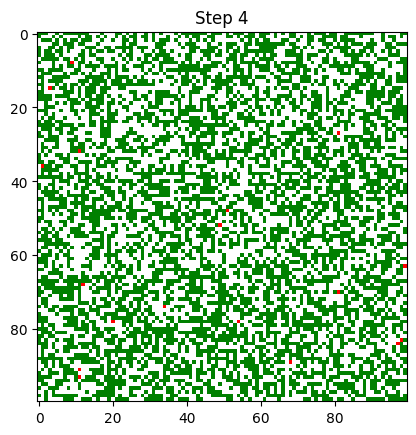

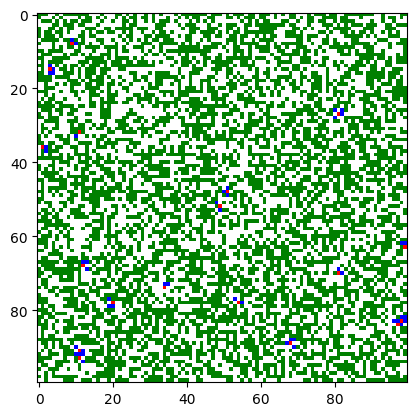

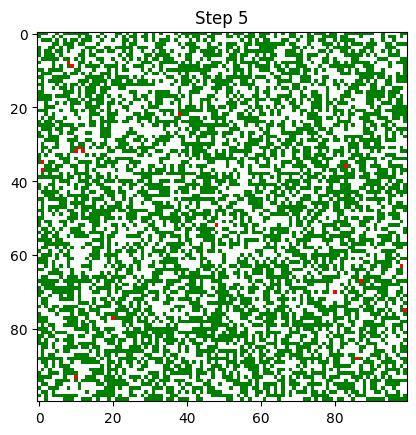

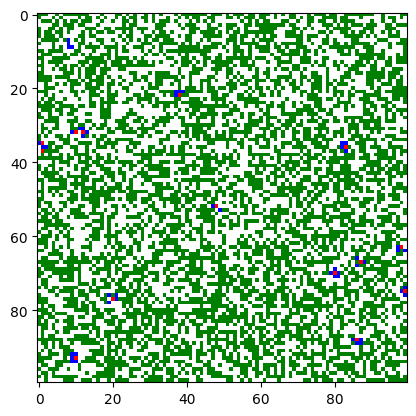

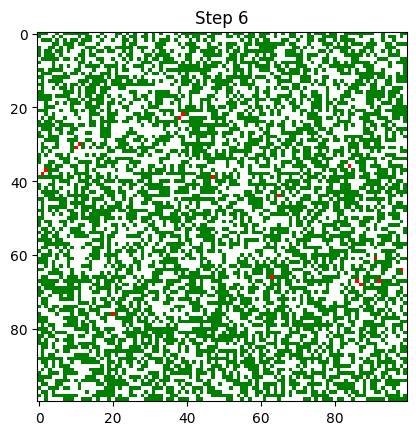

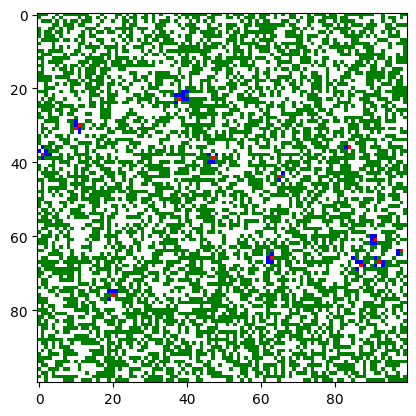

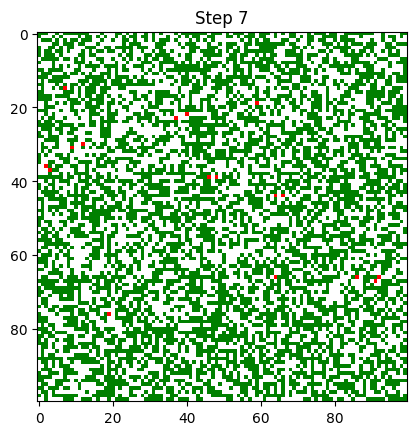

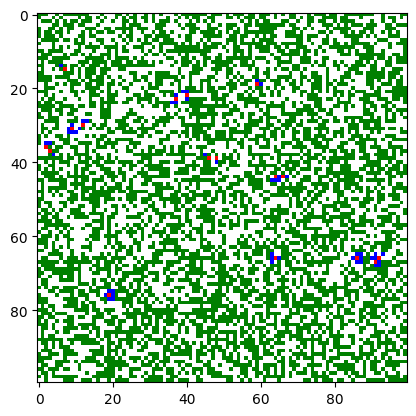

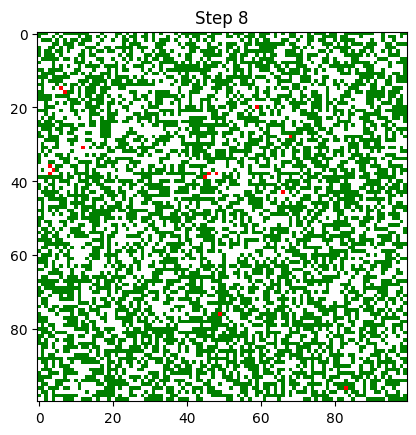

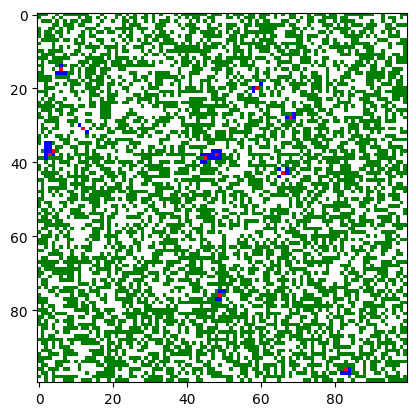

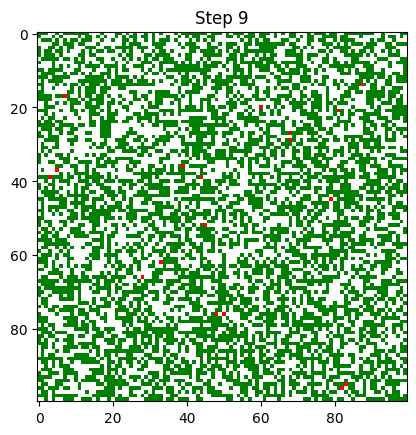

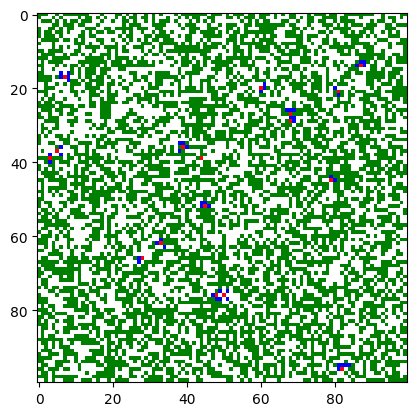

In [45]:
sim1_ff1 = discrete_run_simulation(100, 0.1, 1, 0.005, 0.005/4, 10)

A damage comparison over 200 time steps with the time evolution with and without any firefighting :
![comparison](firefighting_damage_comparison.png)

We find that total damage without any firefighting is equal to 8718.4 units while firefighting reduces the damage significantly to 6145.23 units.

We find in this model of firefighting, firefighters are able to keep the damage low generally except the rare occasions when the fire gets out of hand producing large damage. This happens as long as $f$ is not too small, another reason for this is that tree density increases consistently when the fires are kept in check making fires more likely over time. Thus, we see the need for controlled burning and other strategic forest management methods along with forest fighting emerge in this simple model as well.

## 1D Forest Fires

Up next, we simulate a 1D forest with an interesting choice for parameters. For these choice of parameters (in fact for a range of parameters when $p >> f$) in the limit when forest clusters burn through very quickly compared to the time it takes for tree growth. This is done by burning the entire cluster in one time step whenever a lightning strikes one of the trees in a cluster.

This is in addition to the assumption that lightning strikes are rare : a large number of trees grow between two strikes. This is done by choosing parameters such that $p >> f$,

In [46]:
def initialize_1dforest(p_tree, length):
    '''
    Generates a random lattice with trees and empty sites for a 1d forest. An initialising probability controls the density.
    :param p_tree: Probability of a tree at a point.
    :param length: size of the lattice is just the length of the forest.
    :return: lattice
    '''
    forest = np.random.choice(['e', 't'], p = [1-p_tree, p_tree], size=length)
    return forest

In [47]:
# Initialise a 10^6 sized 1d lattice.
onedforest = initialize_1dforest(0.6,10**6)
vec_onedforest = np.vectorize(char_to_int.get)(onedforest)

The clusters in this forest can be found using the following function :

In [48]:
def find_oned_cluster_sizes(oned_lattice):
    '''
    :param oned_lattice: Forest configuration in one dimension. The one dimensional analog for the two-dimensional cluster finder written above.
    :return: cluster sizes with size bigger than 1
    '''
    cluster_sizes = []
    length, = oned_lattice.shape
    visit_condition = np.zeros_like(oned_lattice, dtype=bool)

    def cluster_size(i, cs):
        if i<0 or i>=length or visit_condition[i] or oned_lattice[i]!='t':
            return cs
        cs+=1
        visit_condition[i] = True
        cs = cluster_size(i+1, cs)
        cs = cluster_size(i-1, cs)
        return cs

    for i in range(length):
        if oned_lattice[i] == 't' and not visit_condition[i]:
            csize = cluster_size(i,0)
            if csize>1:
                cluster_sizes.append(csize)

    return cluster_sizes


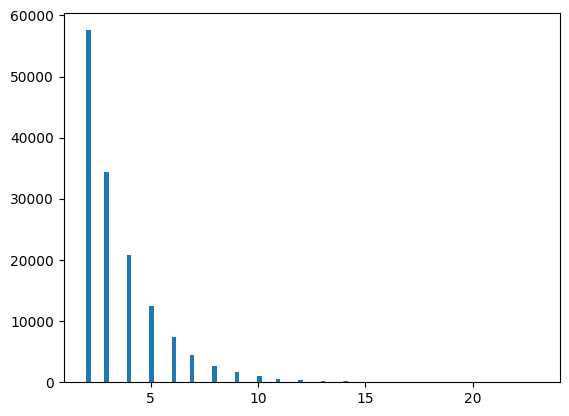

In [49]:
oned_clusters = find_oned_cluster_sizes(onedforest)
plt.hist(oned_clusters, bins=100)
plt.show()

For a given one dimensional lattice, the tree density is given by :

In [50]:
def tree_density(lattice):
    vec_lattice = np.vectorize(char_to_int.get)(lattice)
    total_trees = np.sum(vec_lattice)
    length, = lattice.shape
    rho_tree = total_trees/length
    return rho_tree


The initialised forest has tree density :

In [51]:
tree_density(onedforest)

0.599622

Following the two-dimensional case, we write down the update rules for a single time step for the forest :

In [52]:
def cluster_finder(oned_lattice, site_with_tree):
    '''
    Finds the sites associated with a tree cluster in the "oned_lattice" forest and a tree loaction "site_with_tree".
    :param oned_lattice: the forest
    :param site_with_tree: the site which is part of the cluster.
    :return: sites of the cluster.
    '''
    cluster = []
    length = oned_lattice.shape[0]
    if site_with_tree in np.arange(1, length-1):
        left_site = site_with_tree - 1
        right_site = site_with_tree + 1
        if oned_lattice[site_with_tree] == 't':
            cluster.append(site_with_tree)
            while (oned_lattice[left_site] =='t') and left_site > 0:
                cluster.append(left_site)
                left_site -= 1
            while (oned_lattice[right_site] == 't') and (right_site < length - 1):
                cluster.append(right_site)
                right_site += 1

    return cluster

In [53]:
def oned_update_forest(oned_lattice, p, f):
    '''
    Updates a one dimensional forest by one time unit.
    :param oned_lattice: initial forest configuration
    :param p: growth probability
    :param f: lightning probability
    :return: updated forest
    '''
    length = oned_lattice.shape[0]
    cluster_sites = []
    new_forest = oned_lattice.copy()
    for i in range(length):
        if oned_lattice[i] == 'e':
            if np.random.binomial(1,p)==1:
                     new_forest[i]='t'
        else:
            if np.random.binomial(1,f)==1:
                cluster_sites = cluster_finder(oned_lattice, i)
                for site in cluster_sites:
                    new_forest[site] = 'e'
    return new_forest


Stringing these update rules together, we can simulate a forest evolution for some length of time :


In [54]:
def oned_forest_sim(oned_lattice, p, f, steps):
    densities = np.zeros(steps)
    new_forest = oned_lattice.copy()
    for step in range(steps):
        new_forest = oned_update_forest(new_forest, p, f)
        densities[step] = tree_density(new_forest)

    return densities, new_forest

We update a one dimensional forest with size $10^6$ for $5000$ time steps with $p = 0.01$ and $f = p/100$.

In [149]:
results = oned_forest_sim(onedforest, p=10**(-2), f=10**(-4), steps = 5000)

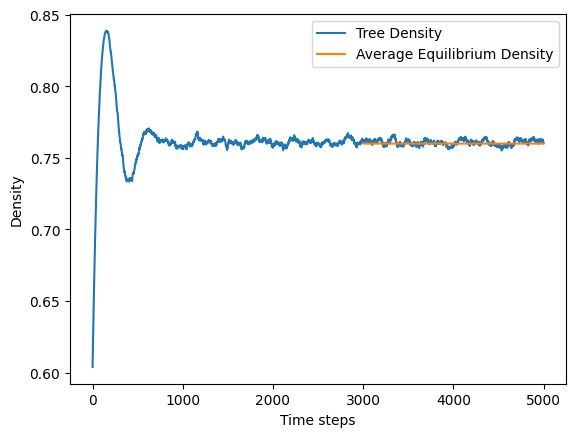

In [217]:
x, y = np.arange(0,5000), results[0]
x2, y2 = np.arange(3000, 5000), np.full(2000, 0.760)
plt.plot(x,y, label = 'Tree Density')
plt.plot(x2, y2, label = 'Average Equilibrium Density')
plt.ylabel('Density')
plt.xlabel('Time steps')
plt.legend()
plt.show()

In [155]:
avg_density = np.sum(y[3000:])/2000
print(avg_density)

0.760826731


The average density $\rho$ equilibriates close to $0.76$. Once at equilibrium the number of trees lost in a time step equal the number of tree that are gained. If the average number of trees that burn in a time step is given by $s$:

$ f s \rho = (1 - \rho) p  $

In [151]:
# Data in results variable are stored in a csv file.
df_onedresult = pd.DataFrame(results)
df_onedresult.to_csv('onedresult.csv')

At equilibrium, we should find that the density becomes constant. The average density value for the last 3000 steps is :


In [166]:
sim_forest = results[1]
sim_clusters = find_oned_cluster_sizes(sim_forest)

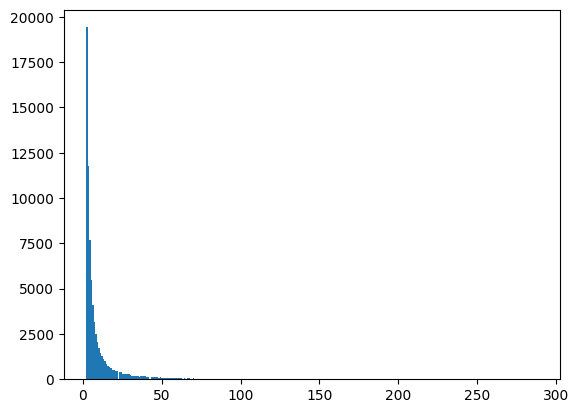

In [172]:
hist, bins = np.histogram(sim_clusters, bins=300)
plt.hist(sim_clusters, bins=300)
plt.show()

We check if the above behaves like a power law :


In [202]:
def power_law(x, a, b):
    return a*x**(-b)

In [175]:
# Fit the curve
params, _ = curve_fit(power_law, bins[:-1], hist)

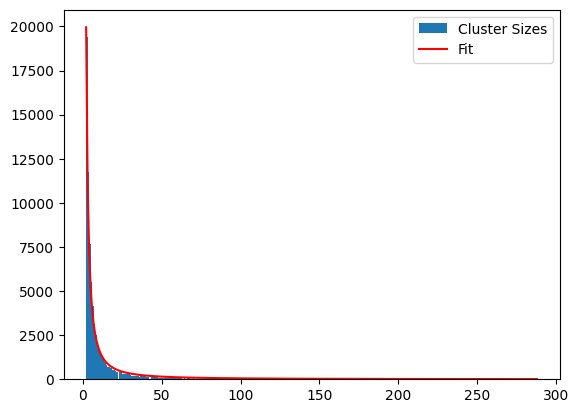

In [182]:
# Plot the histogram and the fitted curve
plt.hist(sim_clusters, bins=300, label='Cluster Sizes')
plt.plot(bins, power_law(bins, *params), 'r-', label='Fit')
plt.legend()
plt.show()

The fitting function is of the form $ax^{-b}$ and fits the data for cluster sizes upto some maximum size for clusters. The values for $a$ and $b$ are :

In [180]:
print(params)

[5.72094858e+04 1.51982454e+00]


This suggests that the forest for these values of the parameters behaves critically i.e is scale invariant upto some  length scale where this behaviour breaks down, when the cluster sizes no longer fit the power law behaviour.